# Experiment about Mean Vector Discretization
This is the comparative experiment to demonstrate the effect of discretization of the mean vector. We run two (1+1)-CMA-ES with margin: one discretizes the mean vector after the update, and another does not.

- Import related packages

In [1]:
import numpy as np
import cma.objective_function.mixed as f_mixed
import cma.optimizer.cmaeswm_elitist as cma_e
import cma.util.sampler as sampler
import cma.util.log as log

- Set optimization setting

In [2]:
def single_run(dim, f, discretization, verbose=False): 
    f.clear()

    # discrete space for binary variables
    if f.__class__.__name__ in ["SphereInt", "EllipsoidInt"]:
        discrete_space = np.tile(np.arange(-10, 11, 1), (f.ind, 1))
    else:
        discrete_space = np.tile(np.arange(0, 2, 1), (f.bid, 1))

    # initial values of Gaussian distribution
    init_m, init_sigma = f_mixed.initial_setting_for_gaussian(f)

    # optimizer
    samp = sampler.Sampler(f, 1)
    opt = cma_e.CMAESwM_elitist(
        dim,                                    # number of dimensions
        discrete_space,                         # definition of search space for discrete variables
        samp,                                   # sampler
        m=init_m, sigma=init_sigma,             # initial distribution parameter
        min_problem=f.minimization_problem,     # True if minimization, False if maximization
        postprocess=False,                      # post-process is efficient for binary and integer optimization
        enc_m=discretization                    # discretize the mean vector ofter update if True
    )
    
    # logger
    result_folder = f'./output_mixed/'
    logger = log.DataLogger(file_name='result_discretization_{}.csv'.format(discretization), path_name=result_folder)
                    
    # run
    opt.run(samp, logger=logger, verbose=verbose)

- Set the setting of design variables and objective function

In [3]:
# ------------------------------
# setting
# ------------------------------
dim = 20                # total number of dimensions
ind = dim // 2          # number of integer variables for SphereInt and EllipsoidInt
bid = dim // 2          # number of binary variables for other objective functions
max_eval = dim * 1e5    # maximum number of evaluation
target_eval = 1e-10     # target evaluation value

# ------------------------------
# select objective function
# ------------------------------
# f = f_mixed.SphereOneMax(d=dim, bid=bid, ind=0, target_eval=target_eval, max_eval=max_eval)
# f = f_mixed.EllipsoidOneMax(d=dim, bid=bid, ind=0, target_eval=target_eval, max_eval=max_eval)
# f = f_mixed.SphereLeadingOnes(d=dim, bid=bid, ind=0, target_eval=target_eval, max_eval=max_eval)
# f = f_mixed.EllipsoidLeadingOnes(d=dim, bid=bid, ind=0, target_eval=target_eval, max_eval=max_eval)
f = f_mixed.SphereInt(d=dim, bid=0, ind=ind, target_eval=target_eval, max_eval=max_eval)
# f = f_mixed.EllipsoidInt(d=dim, bid=0, ind=ind, target_eval=target_eval, max_eval=max_eval)

- Run optimizations with/without discretization of mean vector

In [4]:
# verbose: print the internal information on terminal during the optimization if verbose=True
single_run(dim, f, discretization=True, verbose=False)
single_run(dim, f, discretization=False, verbose=False)

## Visualization of Transition of Best Evaluation Value

- Import related packages (for visualization)

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

- Load the experimental result from csv files

In [6]:
result_true = pd.read_csv('./output_mixed/result_discretization_True.csv')
result_false = pd.read_csv('./output_mixed/result_discretization_False.csv')

- Plot the transition of best evaluation value

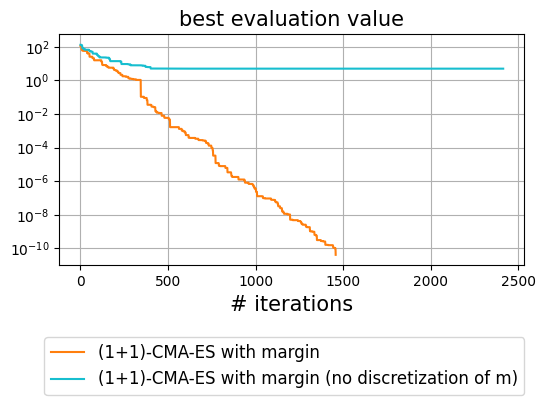

In [7]:
cm = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

axes.plot(result_true["BestEval"], color=cm(1), label="(1+1)-CMA-ES with margin")
axes.plot(result_false["BestEval"], color=cm(10), label="(1+1)-CMA-ES with margin (no discretization of m)")

axes.set_yscale("log")
axes.set_title("best evaluation value", fontsize=15)
axes.set_xlabel("# iterations", fontsize=15)
axes.grid()

fig.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', fontsize=12)